# Self-attention

## Table of contents

1. [Understanding self-attention](#understanding-self-attention)
2. [Setting up the environment](#setting-up-the-environment)
3. [Defining the input data](#defining-the-input-data)
4. [Implementing scaled dot-product attention](#implementing-scaled-dot-product-attention)
5. [Building multi-head self-attention](#building-multi-head-self-attention)
6. [Building the position-wise feed-forward network](#building-the-position-wise-feed-forward-network)
7. [Applying self-attention to a transformer block](#applying-self-attention-to-a-transformer-block)
8. [Training the self-attention mechanism](#training-the-self-attention-mechanism)
9. [Evaluating the self-attention model](#evaluating-the-self-attention-model)
10. [Visualizing attention weights](#visualizing-attention-weights)
11. [Experimenting with hyperparameters](#experimenting-with-hyperparameters)

## Understanding self-attention

### **Key concepts**
Self-attention is a mechanism that allows a model to dynamically weigh the importance of different parts of an input sequence when processing each element. Unlike traditional approaches that rely on fixed-sized context windows, self-attention enables models to capture dependencies across all positions in a sequence, making it especially powerful for tasks with long-range relationships.

Key components of self-attention include:
- **Query, Key, and Value Vectors**: Representations of each input element used to compute attention scores and weighted outputs.
- **Attention Scores**: Measure the relevance of each element in the sequence with respect to the current position, typically using a dot-product or scaled dot-product method.
- **Weighted Aggregation**: Combines all elements of the sequence based on their attention scores, producing context-aware representations.
- **Multi-Head Attention**: Extends self-attention by using multiple attention mechanisms in parallel to capture diverse relationships.

Self-attention forms the foundation of Transformer architectures, which have revolutionized fields like natural language processing and computer vision.

### **Applications**
Self-attention is central to many modern deep learning models, enabling applications such as:
- **Natural language processing (NLP)**: Powering models like BERT, GPT, and Transformer-based translation systems.
- **Image processing**: Capturing spatial relationships in tasks like object detection and image segmentation.
- **Speech recognition**: Modeling dependencies in audio sequences for transcription tasks.
- **Time-series analysis**: Understanding dependencies across long temporal data for forecasting or anomaly detection.

### **Advantages**
- **Global context**: Considers all positions in the sequence simultaneously, capturing long-range dependencies.
- **Scalability**: Works well with variable-length inputs and outputs.
- **Flexibility**: Adapts to diverse data modalities, including text, images, and audio.
- **Parallelization**: Unlike recurrent methods, self-attention allows for parallel computation, significantly speeding up training.

### **Challenges**
- **Computational cost**: Scales quadratically with input sequence length, making it resource-intensive for very long sequences.
- **Memory usage**: Requires substantial memory for large inputs due to the attention matrix.
- **Dependency on large datasets**: Performs best when trained on extensive and diverse datasets.
- **Complexity**: Incorporates many components, requiring careful implementation and tuning for optimal performance.

## Setting up the environment


##### **Q1: How do you install the necessary libraries for building and training self-attention models in PyTorch?**


In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install numpy matplotlib seaborn

##### **Q2: How do you import the required modules for building attention mechanisms and handling data in PyTorch?**


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np

##### **Q3: How do you set up the environment to utilize a GPU for training self-attention models in PyTorch?**

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Defining the input data


##### **Q4: How do you define sequence data, such as tokenized text, to be used as input for the self-attention mechanism?**


In [4]:
vocab_size = 10
seq_len = 6
batch_size = 4

input_seq = torch.randint(0, vocab_size, (batch_size, seq_len)).to(device)

##### **Q5: How do you preprocess and batch the input data to feed into the self-attention model?**


In [5]:
embedding_dim = 32
embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
embedded_input = embedding(input_seq)  # shape: (batch_size, seq_len, embedding_dim)

##### **Q6: How do you create a DataLoader in PyTorch to load batches of sequential data for training?**

In [6]:
class DummySeqDataset(Dataset):
    def __init__(self, num_samples=100):
        self.data = [torch.randint(0, vocab_size, (seq_len,)) for _ in range(num_samples)]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
train_dataset = DummySeqDataset()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Implementing scaled dot-product attention


##### **Q7: How do you implement the function for scaled dot-product attention in PyTorch?**


In [8]:
def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))  # compute raw scores
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))  # apply mask
    attn_weights = F.softmax(scores, dim=-1)  # normalize
    return torch.matmul(attn_weights, v), attn_weights  # weighted sum

##### **Q8: How do you calculate the attention scores by computing the dot product of the query and key matrices?**


In [9]:
q = torch.randn(batch_size, seq_len, embedding_dim).to(device)
k = torch.randn(batch_size, seq_len, embedding_dim).to(device)
v = torch.randn(batch_size, seq_len, embedding_dim).to(device)
scores = torch.matmul(q, k.transpose(-2, -1))  # shape: (batch_size, seq_len, seq_len)

##### **Q9: How do you apply softmax to normalize the attention scores in the scaled dot-product attention mechanism?**


In [ ]:
attn_weights = F.softmax(scores, dim=-1)  # shape: (batch_size, seq_len, seq_len)

##### **Q10: How do you compute the final output of the attention mechanism by multiplying the attention scores with the value matrix?**

In [ ]:
attn_output = torch.matmul(attn_weights, v)  # shape: (batch_size, seq_len, embedding_dim)

## Building multi-head self-attention


##### **Q11: How do you define the architecture for multi-head self-attention using `torch.nn.Module` in PyTorch?**


In [12]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        qkv = self.qkv_proj(x)  # shape: (batch_size, seq_len, 3 * embed_dim)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32).to(x.device))
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().reshape(batch_size, seq_len, self.embed_dim)
        return self.out_proj(attn_output)

##### **Q12: How do you split the input into multiple heads and perform scaled dot-product attention for each head?**


In [13]:
# see Q11

##### **Q13: How do you concatenate the outputs of the multiple attention heads and apply a final linear transformation?**

In [14]:
# see Q11

## Building the position-wise feed-forward network


##### **Q14: How do you define the position-wise feed-forward network using `torch.nn.Linear` layers in PyTorch?**


In [15]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, embed_dim, ff_dim):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))  # apply non-linearity and projection

##### **Q15: How do you apply the feed-forward network to each position in the sequence independently?**


In [16]:
# see Q14's forward pass

##### **Q16: How do you add a non-linearity between the linear layers in the feed-forward network?**

In [17]:
# see Q14's forward pass

## Applying self-attention to a transformer block


##### **Q17: How do you combine multi-head self-attention with layer normalization and residual connections in a transformer block?**


In [18]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ff = PositionwiseFeedForward(embed_dim, ff_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))  # residual connection after norm and attn
        x = x + self.ff(self.norm2(x))  # residual connection after norm and ffn
        return x

##### **Q18: How do you implement the forward pass of the transformer block, including both self-attention and feed-forward layers?**


In [ ]:
# see Q17's forward pass

##### **Q19: How do you stack multiple transformer blocks to create a deep self-attention model?**

In [19]:
class SelfAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.layers = nn.ModuleList([TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)])
        self.classifier = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return self.classifier(x)

## Training the self-attention mechanism


##### **Q20: How do you define the loss function for training a self-attention model in PyTorch?**


In [20]:
criterion = nn.CrossEntropyLoss()

##### **Q21: How do you set up the optimizer to update the parameters of the self-attention model during training?**


In [21]:
model = SelfAttentionModel(vocab_size, 32, 4, 64, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

##### **Q22: How do you implement the training loop for the self-attention mechanism, including forward pass, loss calculation, and backpropagation?**


In [22]:
def train_loop(model, dataloader, optimizer, criterion, epochs=5):
    model.train()
    all_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output.view(-1, vocab_size), batch.view(-1))  # flatten both
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        all_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")
    return all_losses

##### **Q23: How do you track and log the training loss over epochs to monitor the performance of the self-attention model?**

In [23]:
losses = train_loop(model, train_loader, optimizer, criterion, epochs=10)

Epoch 1: Loss = 1.5133
Epoch 2: Loss = 0.3226
Epoch 3: Loss = 0.0542
Epoch 4: Loss = 0.0201
Epoch 5: Loss = 0.0117
Epoch 6: Loss = 0.0080
Epoch 7: Loss = 0.0058
Epoch 8: Loss = 0.0045
Epoch 9: Loss = 0.0035
Epoch 10: Loss = 0.0029


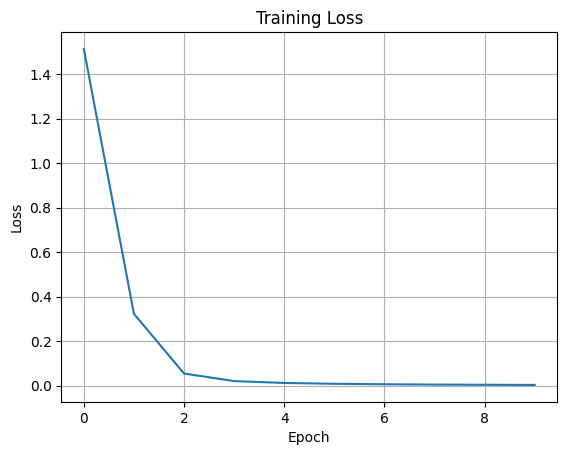

In [24]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

## Evaluating the self-attention model


##### **Q24: How do you evaluate the self-attention model on validation or test data after training?**


In [25]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output.view(-1, vocab_size), batch.view(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [26]:
val_loss = evaluate(model, train_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 0.0026


##### **Q25: How do you calculate the accuracy or other metrics to assess the model’s performance?**


In [27]:
def calculate_accuracy(model, dataloader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            preds = output.argmax(dim=-1)
            total += batch.numel()
            correct += (preds == batch).sum().item()
    return correct / total

In [28]:
accuracy = calculate_accuracy(model, train_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


##### **Q26: How do you implement a function to perform inference using the trained self-attention model on new input sequences?**

In [29]:
def infer(model, input_seq):
    model.eval()
    with torch.no_grad():
        input_seq = input_seq.to(device)
        output = model(input_seq)
        return output.argmax(dim=-1)

In [30]:
new_input = torch.randint(0, vocab_size, (1, seq_len)).to(device)  # dummy input sequence
predicted_output = infer(model, new_input)
print("Input:", new_input.cpu().tolist())
print("Predicted:", predicted_output.cpu().tolist())

Input: [[5, 0, 6, 6, 4, 0]]
Predicted: [[5, 0, 6, 6, 4, 0]]


## Visualizing attention weights


##### **Q27: How do you extract attention weights from the model to analyze how the self-attention mechanism focuses on different parts of the input sequence?**


In [41]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, return_weights=False):
        batch_size, seq_len, _ = x.size()
        qkv = self.qkv_proj(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32).to(x.device))
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().reshape(batch_size, seq_len, self.embed_dim)
        if return_weights:
            return self.out_proj(attn_output), attn_weights
        return self.out_proj(attn_output)

In [42]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ff = PositionwiseFeedForward(embed_dim, ff_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, return_weights=False):
        if return_weights:
            attn_out, attn_weights = self.attn(self.norm1(x), return_weights=True)
            x = x + attn_out
            x = x + self.ff(self.norm2(x))
            return x, attn_weights
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

In [43]:
class SelfAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.layers = nn.ModuleList([TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)])
        self.classifier = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, return_weights=False):
        x = self.embedding(x)
        attn_weights_all = []
        for layer in self.layers:
            if return_weights:
                x, attn_weights = layer(x, return_weights=True)
                attn_weights_all.append(attn_weights)
            else:
                x = layer(x)
        logits = self.classifier(x)
        if return_weights:
            return logits, attn_weights_all
        return logits

In [44]:
model_with_attn = SelfAttentionModel(vocab_size, 32, 4, 64, 2).to(device)
model_with_attn.load_state_dict(model.state_dict())  # reuse learned weights

_, attn_weights = model_with_attn(new_input, return_weights=True)
print(f"Extracted attention weights shape: {attn_weights[0].shape}")  # (batch, heads, seq_len, seq_len)

Extracted attention weights shape: torch.Size([1, 4, 6, 6])


##### **Q28: How do you visualize the attention weights as heatmaps to show which tokens or elements the model attends to during the forward pass?**


In [45]:
def plot_attention(attn_weights):
    avg_weights = attn_weights.mean(dim=1)[0].detach().cpu().numpy()  # average over heads
    plt.imshow(avg_weights, cmap='viridis')
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.colorbar()
    plt.title("Attention Weights Heatmap")
    plt.show()

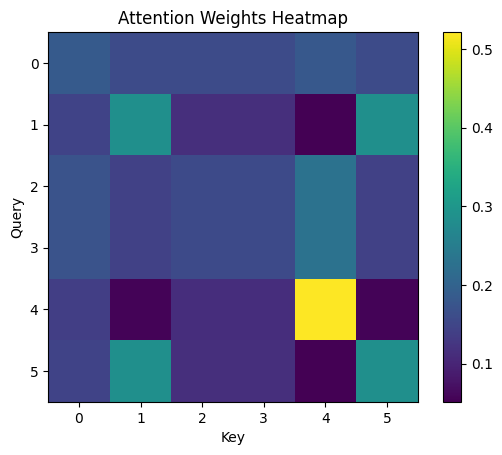

In [46]:
plot_attention(attn_weights[0])

##### **Q29: How do you interpret the attention heatmaps to understand how attention is distributed across layers and heads?**

In [47]:
print("Token-to-token attention matrix (head 0, first layer):")
print(attn_weights[0][0, 0].detach().cpu().numpy())  # first sample, first head

Token-to-token attention matrix (head 0, first layer):
[[0.14181168 0.21660401 0.16228434 0.16228434 0.1004116  0.21660401]
 [0.0286951  0.35881448 0.1047312  0.1047312  0.04421364 0.35881448]
 [0.09184583 0.20329945 0.22606175 0.22606175 0.04943175 0.20329945]
 [0.09184583 0.20329945 0.22606175 0.22606175 0.04943175 0.20329945]
 [0.19862875 0.03242758 0.04059549 0.04059549 0.6553251  0.03242758]
 [0.0286951  0.35881448 0.1047312  0.1047312  0.04421364 0.35881448]]


## Experimenting with hyperparameters


##### **Q30: How do you experiment with different numbers of attention heads and analyze their effect on model performance and training time?**


In [48]:
for num_heads in [2, 4, 8]:
    temp_model = SelfAttentionModel(vocab_size, 32, num_heads, 64, 2).to(device)
    temp_optimizer = torch.optim.Adam(temp_model.parameters(), lr=1e-3)
    print(f"\nTraining with {num_heads} heads:")
    train_loop(temp_model, train_loader, temp_optimizer, criterion, epochs=3)


Training with 2 heads:
Epoch 1: Loss = 1.7467
Epoch 2: Loss = 0.4300
Epoch 3: Loss = 0.0750

Training with 4 heads:
Epoch 1: Loss = 1.3667
Epoch 2: Loss = 0.2976
Epoch 3: Loss = 0.0538

Training with 8 heads:
Epoch 1: Loss = 1.4044
Epoch 2: Loss = 0.3385
Epoch 3: Loss = 0.0596


##### **Q31: How do you adjust the hidden dimension size of the self-attention mechanism and observe its impact on accuracy and convergence?**


In [49]:
for embed_dim in [16, 32, 64]:
    temp_model = SelfAttentionModel(vocab_size, embed_dim, 4, 64, 2).to(device)
    temp_optimizer = torch.optim.Adam(temp_model.parameters(), lr=1e-3)
    print(f"\nTraining with embedding dim {embed_dim}:")
    train_loop(temp_model, train_loader, temp_optimizer, criterion, epochs=3)


Training with embedding dim 16:
Epoch 1: Loss = 2.0228
Epoch 2: Loss = 1.0745
Epoch 3: Loss = 0.4269

Training with embedding dim 32:
Epoch 1: Loss = 1.3445
Epoch 2: Loss = 0.3042
Epoch 3: Loss = 0.0556

Training with embedding dim 64:
Epoch 1: Loss = 1.0269
Epoch 2: Loss = 0.0372
Epoch 3: Loss = 0.0064


##### **Q32: How do you experiment with varying the number of transformer blocks in the model and analyze how it affects the results?**


In [50]:
for num_layers in [1, 2, 4]:
    temp_model = SelfAttentionModel(vocab_size, 32, 4, 64, num_layers).to(device)
    temp_optimizer = torch.optim.Adam(temp_model.parameters(), lr=1e-3)
    print(f"\nTraining with {num_layers} transformer blocks:")
    train_loop(temp_model, train_loader, temp_optimizer, criterion, epochs=3)


Training with 1 transformer blocks:
Epoch 1: Loss = 1.5968
Epoch 2: Loss = 0.6041
Epoch 3: Loss = 0.1554

Training with 2 transformer blocks:
Epoch 1: Loss = 1.8826
Epoch 2: Loss = 0.4580
Epoch 3: Loss = 0.0784

Training with 4 transformer blocks:
Epoch 1: Loss = 1.1107
Epoch 2: Loss = 0.1254
Epoch 3: Loss = 0.0233


##### **Q33: How do you tune learning rates and dropout rates to improve the generalization of the self-attention model?**


In [51]:
for lr in [1e-4, 1e-3, 1e-2]:
    temp_model = SelfAttentionModel(vocab_size, 32, 4, 64, 2).to(device)
    temp_optimizer = torch.optim.Adam(temp_model.parameters(), lr=lr)
    print(f"\nTraining with learning rate {lr}:")
    train_loop(temp_model, train_loader, temp_optimizer, criterion, epochs=3)


Training with learning rate 0.0001:
Epoch 1: Loss = 2.3815
Epoch 2: Loss = 2.1971
Epoch 3: Loss = 2.0263

Training with learning rate 0.001:
Epoch 1: Loss = 1.5310
Epoch 2: Loss = 0.3275
Epoch 3: Loss = 0.0546

Training with learning rate 0.01:
Epoch 1: Loss = 0.2920
Epoch 2: Loss = 0.0000
Epoch 3: Loss = 0.0000


##### **Q34: How do you analyze the effect of different activation functions in the feed-forward network on training stability?**

In [52]:
class PositionwiseFeedForwardAct(nn.Module):
    def __init__(self, embed_dim, ff_dim, activation):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)
        self.activation = activation

    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x)))

In [53]:
class TransformerBlockAct(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, activation):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ff = PositionwiseFeedForwardAct(embed_dim, ff_dim, activation)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

In [54]:
class SelfAttentionModelAct(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, activation):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.layers = nn.ModuleList([TransformerBlockAct(embed_dim, num_heads, ff_dim, activation) for _ in range(num_layers)])
        self.classifier = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return self.classifier(x)

In [55]:
for act_fn in [F.relu, F.gelu, F.leaky_relu]:
    temp_model = SelfAttentionModelAct(vocab_size, 32, 4, 64, 2, act_fn).to(device)
    temp_optimizer = torch.optim.Adam(temp_model.parameters(), lr=1e-3)
    print(f"\nTraining with activation: {act_fn.__name__}")
    train_loop(temp_model, train_loader, temp_optimizer, criterion, epochs=3)


Training with activation: relu
Epoch 1: Loss = 1.7794
Epoch 2: Loss = 0.4392
Epoch 3: Loss = 0.0693

Training with activation: gelu
Epoch 1: Loss = 1.7056
Epoch 2: Loss = 0.3986
Epoch 3: Loss = 0.0597

Training with activation: leaky_relu
Epoch 1: Loss = 1.5371
Epoch 2: Loss = 0.3176
Epoch 3: Loss = 0.0527
